In [ ]:
!pip install gensim

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install fasttext

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import drive
drive.mount("/content/drive/")

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns

import re
from tqdm.notebook import tqdm
from datetime import datetime
from functools import reduce
from operator import add
from collections import Counter

import nltk
from nltk.tokenize import TreebankWordTokenizer, TweetTokenizer
nltk.download('stopwords')
from nltk.corpus import stopwords
stopwords = list(set(stopwords.words('indonesian')))
from gensim.models.phrases import Phrases, Phraser
from string import punctuation
punctuation = list(punctuation)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
data_news = pd.read_csv('/content/drive/MyDrive/[CAPSTONE OASEE]/[ML]/[2.1] Dataset/Combined /combined_all_data.csv')
data_news.head()

,Title,Timestamp,FullText,Tags,Author,Url,Label
0,NTT Optimistis Persentase Anak Stunting Turun ...,17/05/2023,Pencatatan dan Pelaporan Gizi Berbasis Masyara...,NTT stunting SDG02 Tanpa Kelaparan SDG06 Air B...,Danur Lambang Pristiandaru ;Danur Lambang Pris...,http://lestari.kompas.com/read/2023/05/17/2255...,0
1,Kemenperin Industri Manufaktur Sumbang 70 21 ...,17/05/2023,Kementerian Perindustrian Kemenperin mengatak...,Ekspor Kemenperin industri manufaktur,Haryanti Puspa Sari ;Akhdi Martin Pratama,http://money.kompas.com/read/2023/05/17/210000...,0
2,Tingkatkan Daya Saing Nasional Industri Hijau...,17/05/2023,Menteri Perindustrian Menperin Agus Gumiwang ...,industri hijau SDG08 Pekerjaan Layak dan Pertu...,Danur Lambang Pristiandaru ;Danur Lambang Pris...,http://lestari.kompas.com/read/2023/05/17/1700...,0
3,Ganjil Genap di Jalur Puncak Berlaku Mulai Har...,17/05/2023,Untuk mencegah terjadinya kemacetan luar bias...,ganjil genap libur nasional polres bogor Kawas...,Donny Dwisatryo Priyantoro ;Azwar Ferdian,http://otomotif.kompas.com/read/2023/05/17/152...,0
4,Daftar Lengkap 54 Taman Nasional di Indonesia,17/05/2023,unsur hayati di alam yang terdiri dari sumber ...,Taman Nasional SDG14 Ekosistem Lautan SDG15 Ek...,Danur Lambang Pristiandaru ;Danur Lambang Pris...,http://lestari.kompas.com/read/2023/05/17/1500...,0


In [ ]:
print(data_news.shape)
print(50*'-')
print(data_news.info())

(600, 7)
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Title      600 non-null    object
 1   Timestamp  300 non-null    object
 2   FullText   600 non-null    object
 3   Tags       300 non-null    object
 4   Author     300 non-null    object
 5   Url        600 non-null    object
 6   Label      600 non-null    int64 
dtypes: int64(1), object(6)
memory usage: 32.9+ KB
None


In [ ]:
data_news['Tags'].fillna('', inplace=True)

In [ ]:
data_news['FullText'] = data_news['Title']+' '+data_news['Tags']+' '+data_news['FullText']
data_news = data_news.drop(['Url', 'Title', 'Timestamp', 'Tags', 'Author'], axis=1)
data_news.head()

,FullText,Label
0,NTT Optimistis Persentase Anak Stunting Turun ...,0
1,Kemenperin Industri Manufaktur Sumbang 70 21 ...,0
2,Tingkatkan Daya Saing Nasional Industri Hijau...,0
3,Ganjil Genap di Jalur Puncak Berlaku Mulai Har...,0
4,Daftar Lengkap 54 Taman Nasional di Indonesia ...,0


In [ ]:
data_news.isna().sum()

FullText    0
Label       0
dtype: int64

In [ ]:
print(data_news['Label'])

0      0
1      0
2      0
3      0
4      0
      ..
595    1
596    1
597    1
598    1
599    1
Name: Label, Length: 600, dtype: int64


In [ ]:
print(data_news['Label'].value_counts())

0    300
1    300
Name: Label, dtype: int64


<Axes: xlabel='Label', ylabel='count'>

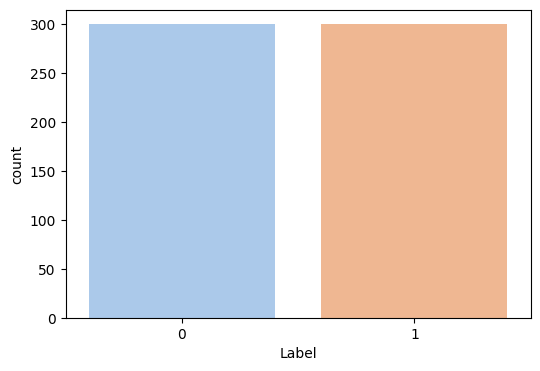

In [ ]:
plt.figure(figsize=(6,4))
sns.countplot(data=data_news, x='Label', palette='pastel')

Text(0.5, 1.0, 'False texts')

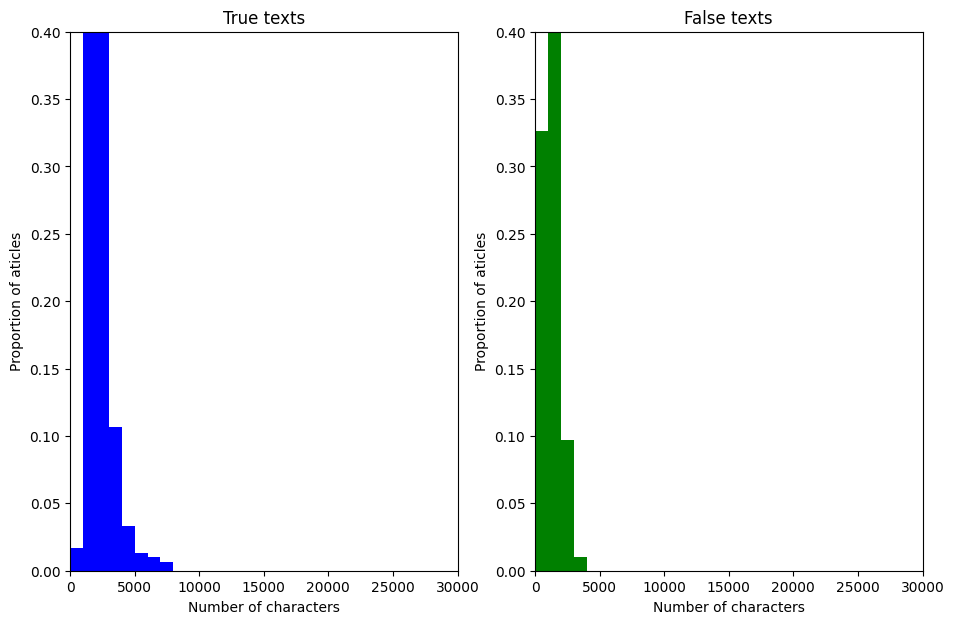

In [ ]:
# Characters length of articles
len_cha_true = data_news[data_news['Label'] == 0]['FullText'].apply(lambda x: len(x))
len_cha_false = data_news[data_news['Label'] == 1]['FullText'].apply(lambda x: len(x))

bins_ = [i * 1000 for i in range(0,31)]

fig, (hist1, hist2) = plt.subplots(1,2, figsize = (11,7))
hist1.hist(len_cha_true, bins = bins_, weights = np.ones(len(len_cha_true))/len(len_cha_true), color = 'b')
hist1.set_ylim(0, top=0.4)
hist1.set_xlim(0, 30000)
hist1.set_xlabel('Number of characters')
hist1.set_ylabel('Proportion of aticles')
hist1.set_title('True texts')

hist2.hist(len_cha_false, bins = bins_, weights = np.ones(len(len_cha_false))/len(len_cha_false), color = 'g')
hist2.set_ylim(0, top=0.4)
hist2.set_xlim(0, 30000)
hist2.set_xlabel('Number of characters')
hist2.set_ylabel('Proportion of aticles')
hist2.set_title('False texts')

Text(0.5, 1.0, 'False texts')

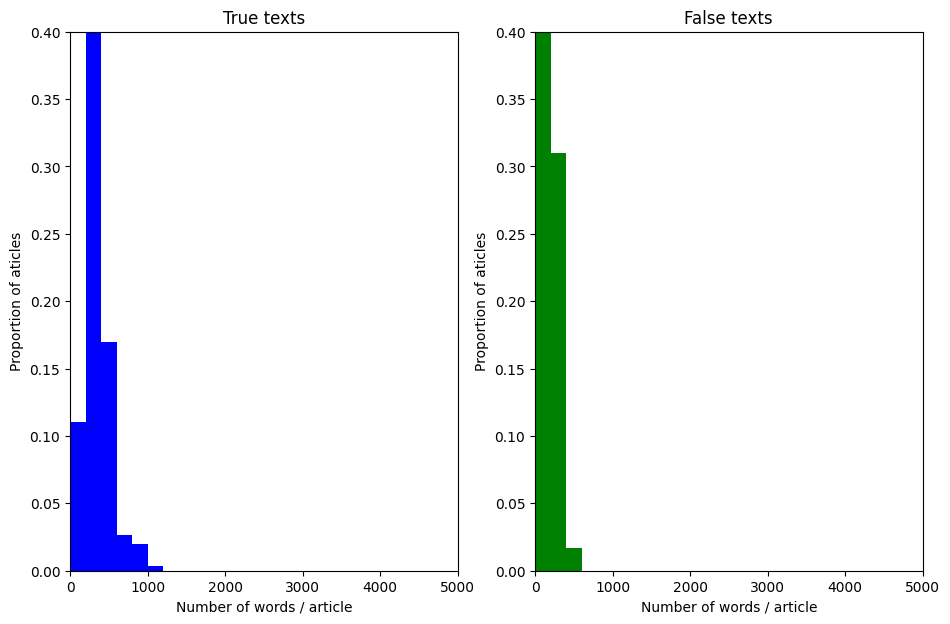

In [ ]:
# Number of words per article
len_w_true = data_news[data_news['Label'] == 0]['FullText'].str.split().map(lambda x: len(x))
len_w_false = data_news[data_news['Label'] == 1]['FullText'].str.split().map(lambda x: len(x))


bins_ = [i * 200 for i in range(0,26)]

fig, (hist1, hist2) = plt.subplots(1,2, figsize = (11,7))
hist1.hist(len_w_true, bins = bins_, weights = np.ones(len(len_w_true))/len(len_w_true), color = 'b')
hist1.set_ylim(0, top=0.4)
hist1.set_xlim(0, 5000)
hist1.set_xlabel('Number of words / article')
hist1.set_ylabel('Proportion of aticles')
hist1.set_title('True texts')
hist2.hist(len_w_false, bins = bins_, weights = np.ones(len(len_w_false))/len(len_w_false), color = 'g')
hist2.set_ylim(0, top=0.4)
hist2.set_xlim(0, 5000)
hist2.set_xlabel('Number of words / article')
hist2.set_ylabel('Proportion of aticles')
hist2.set_title('False texts')

In [ ]:
stop = stopwords + punctuation + ['“','’', '“', '”', '‘','...']
tqdm.pandas()

def lowerizer(article):
  """
  Lowerize a given text
  ----
  Inputs : 
    article (str) : text to be pre-processed
  Outputs : 
    article.lower() (str) : lowerized text
  """
  return article.lower()

def remove_html(article):
    """
    Remove HTML tags from a given text
    ----
    Inputs : 
      article (str) : text to be pre-processed
    Outputs : 
      article (str) : text cleaned of HTML tags
    """
    article = re.sub("()", "", article, flags=re.DOTALL)
    return article

def remove_url(article):
    """
    Remove URL tags from a given text
    ----
    Inputs : 
      article (str) : text to be pre-processed
    Outputs : 
      article (str) : text cleaned of URL tags
    """
    article = re.sub(r'https?:\/\/.\S+', "", article)
    return article

def remove_hashtags(article):
    """
    Remove hashtags from a given text
    ----
    Inputs : 
      article (str) : text to be pre-processed
    Outputs : 
      article (str) : text cleaned of hashtags
    """
    article = re.sub("#"," ",article)
    return article

def remove_a(article):
    """
    Remove twitter account references @ rom a given text
    ----
    Inputs : 
      article (str) : text to be pre-processed
    Outputs : 
      article (str) : text withouttwitter account references 
    """
    article = re.sub("@"," ",article)
    return article

def remove_brackets(article):
    """
    Remove square brackets from a given text 
    ----
    Inputs : 
      article (str) : text to be pre-processed
    Outputs : 
      article (str) : text without square brackets
    """
    article = re.sub('', '', article)
    return article

def remove_stop_punct(article):
    """
    Remove punctuation and stopwords from a given text
    ----
    Inputs : 
      article (str) : text to be pre-processed
    Outputs : 
      article (str) : text without punctuation or stopwords
    """
    final_article = []
    for i in article.split():
        if i not in stop:
            final_article.append(i.strip())
    return " ".join(final_article)

def preprocessing(article):
    """
    Computes the above-define steps to clean a given text
    ----
    Inputs : 
      article (str) : text to be pre-processed
    Outputs : 
      article (str) : pre-processed text
    """
    article = lowerizer(article)
    article = remove_html(article)
    article = remove_url(article)
    article = remove_hashtags(article)
    article = remove_a(article)
    article = remove_brackets(article)
    article = remove_stop_punct(article)
    return article

In [ ]:
data_news['FullText'] = data_news['FullText'].progress_apply(lambda x : preprocessing(x))

  0%|          | 0/600 [00:00<?, ?it/s]

In [ ]:
data_news

,FullText,Label
0,ntt optimistis persentase anak stunting turun ...,0
1,kemenperin industri manufaktur sumbang 70 21 p...,0
2,tingkatkan daya saing nasional industri hijau ...,0
3,ganjil genap jalur puncak berlaku ganjil genap...,0
4,daftar lengkap 54 taman nasional indonesia tam...,0
...,...,...
595,giveaway soimah pancawati akun mae soimahh pen...,1
596,irish bella gugat cerai ammar zoni channel you...,1
597,video china singapur bangunin macan tidur mala...,1
598,pilot sengaja melepas bahan kimia pesawat band...,1


In [ ]:
from wordcloud import WordCloud,STOPWORDS
def wordcloud(corpus, title): 
  wordcloud = WordCloud(width = 1000, height = 500, stopwords=STOPWORDS, background_color='white').generate(" ".join(corpus))
  plt.figure(figsize=(15,8))
  plt.imshow(wordcloud)
  plt.title(title)
  plt.axis("off")
  plt.show()

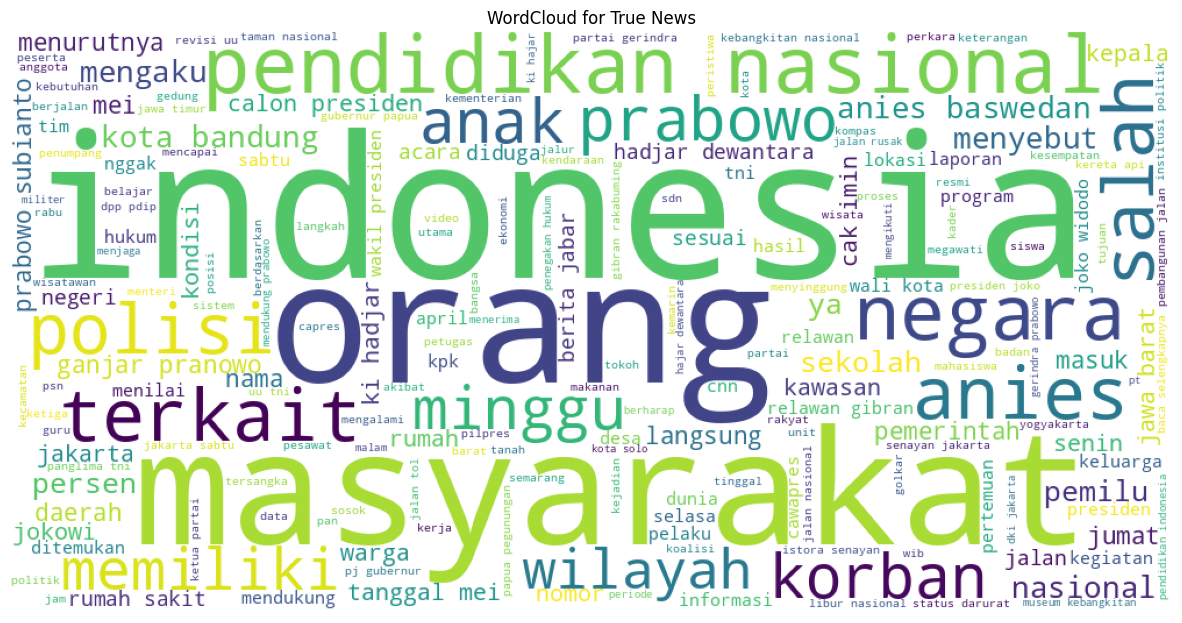

In [ ]:
wordcloud(data_news[data_news['Label']==0]['FullText'], "WordCloud for True News")

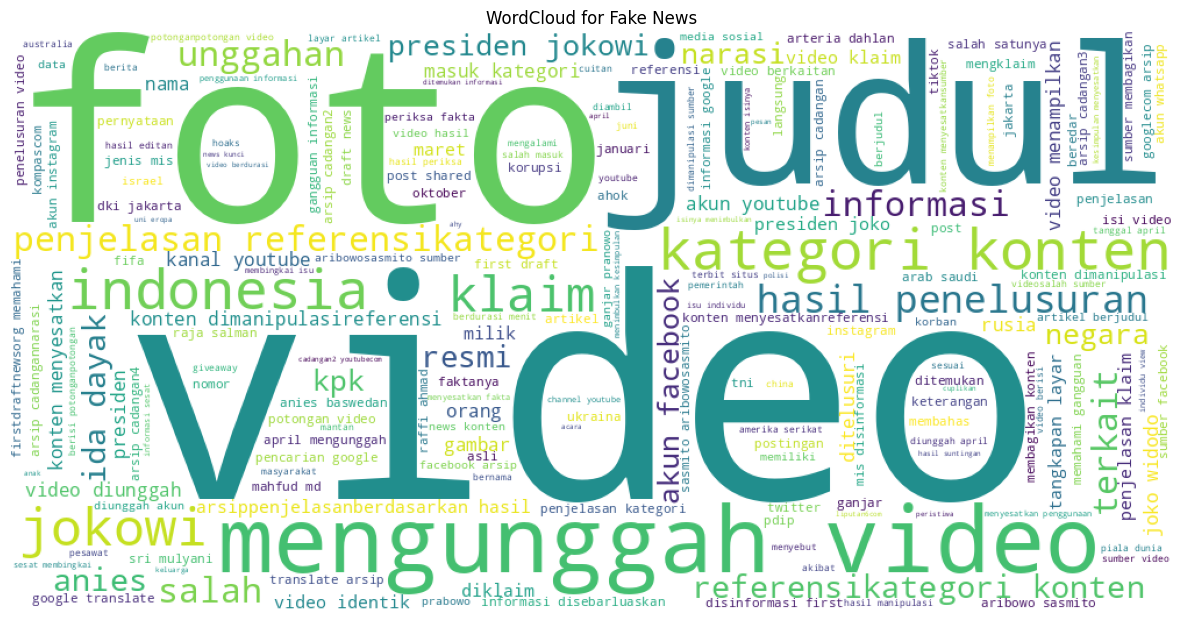

In [ ]:
wordcloud(data_news[data_news['Label']==1]['FullText'], "WordCloud for Fake News")

#Model

##Preparation

In [ ]:
import torch
from torch import nn
import torch.optim as optim
import nltk
from nltk import word_tokenize
nltk.download('punkt')
from torch.nn.utils.rnn import pad_sequence
import random
from torch.utils.data import Dataset, DataLoader

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
def get_splits(x, y, splits):
  """
  Split the features and target variables into training, validation and testing datasets 
  ------
  Inputs : 
    x (pd.Serie) : cleaned articles 
    y (pd.Serie) : target variable
    splits (floats tuple) : proportion of training and validation samples 
  Outputs : 
    (train_x, train_y), (valid_x, valid_y), (test_x, test_y) (numpy arrays) : splitted datasets between training features and targets, validation features and targets, testing features and targets
  """
    # Create an index list and shuffle it
  n = len(x)
  indexes = np.arange(n)
  random.shuffle(indexes)

  # Find the two indexes we'll use to cut the lists from the splits
  valid_begin = int(splits[0]*n)
  test_begin = valid_begin + int(splits[1]*n)
  
  # We process the splitting using our defined indexes
  train_x, train_y = np.array(x)[indexes[:valid_begin]], np.array(y)[indexes[:valid_begin]]
  valid_x, valid_y = np.array(x)[indexes[valid_begin:test_begin]], np.array(y)[indexes[valid_begin:test_begin]]
  test_x, test_y = np.array(x)[indexes[test_begin:]], np.array(y)[indexes[test_begin:]]
  return (train_x, train_y), (valid_x, valid_y), (test_x, test_y)

In [ ]:
splits = (0.8, 0.1)
(train_x, train_y), (valid_x, valid_y), (test_x, test_y) = get_splits(data_news['FullText'], data_news['Label'], splits)
(len(train_x), len(train_y)), (len(valid_x), len(valid_y)), (len(test_x), len(test_y))

((480, 480), (60, 60), (60, 60))

In [ ]:
def distribution_data(corpus): 
  """
  Returns number of fake and true news in a given dataset
  ----
  Inputs : 
    corpus (array) : labels of our dataset
  Outputs : 
    distrib (pd.DataFrame) : number of true and fake news in the dataset 
  """
  nb_true = corpus.sum()
  nb_false = len(corpus) - nb_true
  distrib = pd.DataFrame(data = {'Number of samples': [nb_true, nb_false], 'Label':['True', 'False']})
  return distrib
     

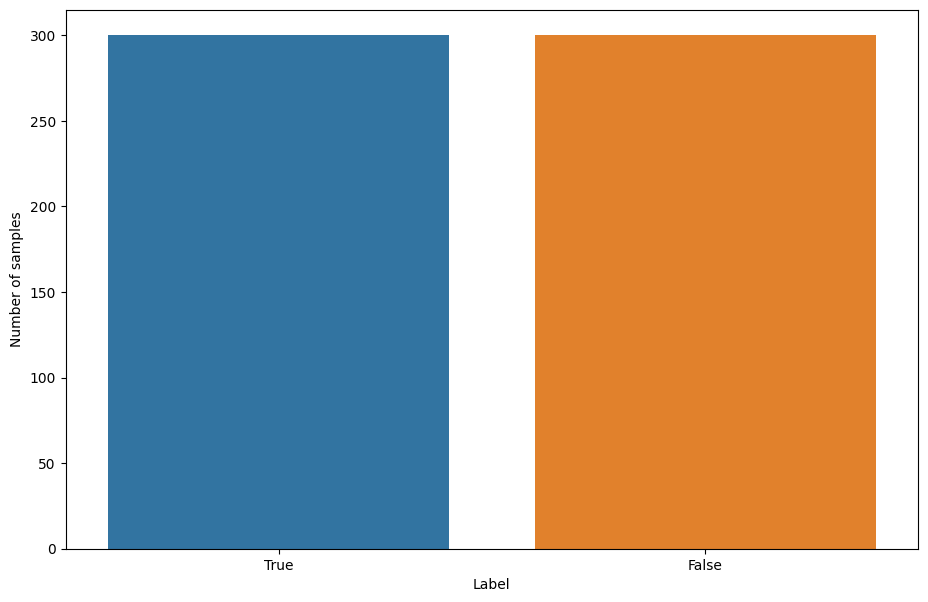

In [ ]:
distrib = distribution_data(data_news['Label'])
fig, bar = plt.subplots(figsize = (11,7))
bar = sns.barplot(y='Number of samples', x='Label',data=distrib)

<Axes: xlabel='Label', ylabel='Number of samples'>

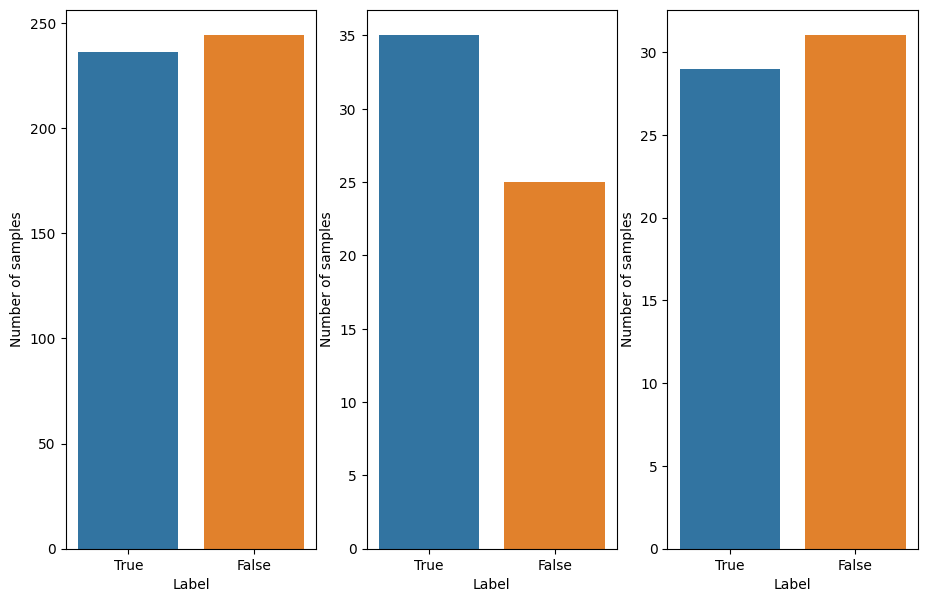

In [ ]:
train_distrib = distribution_data(train_y)
valid_distrib = distribution_data(valid_y)
test_distrib = distribution_data(test_y)

fig, (bar1, bar2, bar3) = plt.subplots(1,3, figsize = (11,7))
sns.barplot(y='Number of samples', x='Label',data=train_distrib, ax = bar1)
sns.barplot(y='Number of samples', x='Label',data=valid_distrib, ax = bar2)
sns.barplot(y='Number of samples', x='Label',data=test_distrib, ax = bar3)

In [ ]:
class TextClassificationDataset(Dataset):
    def __init__(self, data, categories, vocab = None, max_length = 100, min_freq = 5):
        
        self.data = data
        self.max_length = max_length
        
        # Allow to import a vocabulary (validation and testing will use the training vocabulary)
        if vocab is not None:
            self.word2idx, self.idx2word = vocab
        else:
            # Build the vocabulary if none is imported
            self.word2idx, self.idx2word = self.build_vocab(self.data, min_freq)
        
        # We tokenize the articles
        tokenized_data = [word_tokenize(file.lower()) for file in self.data]
        # Transform words into lists of indexes
        indexed_data = [[self.word2idx.get(word, self.word2idx['UNK']) for word in file] for file in tokenized_data]
        # Transform into a list of Pytorch LongTensors
        tensor_data = [torch.LongTensor(file) for file in indexed_data]
        # Lables are passed into a FloatTensor
        tensor_y = torch.FloatTensor(categories)
        # Finally we cut too the determined maximum length
        cut_tensor_data = [tensor[:max_length] for tensor in tensor_data]
        # We pad the sequences to have the whole dataset containing sequences of the same length
        self.tensor_data = pad_sequence(cut_tensor_data, batch_first=True, padding_value=0)
        self.tensor_y = tensor_y
        
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        return self.tensor_data[idx], self.tensor_y[idx] 
    
    def build_vocab(self, corpus, count_threshold):
        word_counts = {}
        for sent in corpus:
            for word in word_tokenize(sent.lower()):
                if word not in word_counts:
                    word_counts[word] = 0
                word_counts[word] += 1   
        filtered_word_counts = {word: count for word, count in word_counts.items() if count >= count_threshold}        
        words = sorted(filtered_word_counts.keys(), key=word_counts.get, reverse=True) + ['UNK']
        word_index = {words[i] : (i+1) for i in range(len(words))}
        idx_word = {(i+1) : words[i] for i in range(len(words))}
        return word_index, idx_word
    
    def get_vocab(self):
        return self.word2idx, self.idx2word

In [ ]:
training_dataset = TextClassificationDataset(train_x, train_y)
training_word2idx, training_idx2word = training_dataset.get_vocab()
valid_dataset = TextClassificationDataset(valid_x, valid_y, (training_word2idx, training_idx2word))
test_dataset = TextClassificationDataset(test_x, test_y, (training_word2idx, training_idx2word))

In [ ]:
training_dataloader = DataLoader(training_dataset, batch_size = 200, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size = 25)
test_dataloader = DataLoader(test_dataset, batch_size = 25)

##Embeddings

In [ ]:
# import fasttext.util
# fasttext.util.download_model('id', if_exists='ignore')

In [ ]:
import fasttext
from gensim.models import FastText

model_path = "cc.id.300.bin"
loaded_fasttext_model = fasttext.load_model(model_path)

In [ ]:
def get_fasttext_adapted_embeddings(fasttext_model, input_voc):
    """
    Retrieve vocabulary words' embeddings from fastText
    ----
    Inputs:
        fasttext_model (gensim.models.FastText): fastText embedding model
        input_voc (dict): dictionary of our indexed vocabulary
    Outputs:
        embeddings (ndarray): fastText embeddings for the given vocabulary with the vocabulary index
    """
    embeddings = np.zeros((len(input_voc) + 1, fasttext_model.get_dimension()))
    for word, index in input_voc.items():
        if word in fasttext_model:
            embeddings[index] = fasttext_model[word]
    return embeddings

FastTextEmbeddings = get_fasttext_adapted_embeddings(loaded_fasttext_model, training_word2idx)

In [ ]:
class LSTMModel(nn.Module):

    def __init__(self, embedding_dim, vocabulary_size, hidden_dim, embeddings=None, fine_tuning=False):
        super().__init__()
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        if embeddings:
            self.embeddings = nn.Embedding.from_pretrained(torch.FloatTensor(FastTextEmbeddings), freeze=not fine_tuning, padding_idx=0)
        else:
            self.embeddings = nn.Embedding(num_embeddings=vocabulary_size+1, embedding_dim=embedding_dim, padding_idx=0)

        self.lstm = nn.LSTM(input_size=embedding_dim, hidden_size=hidden_dim, batch_first=True, num_layers=2)
        self.linear = nn.Linear(in_features=2*hidden_dim, out_features=1)

    def forward(self, inputs):
        emb = self.embeddings(inputs)
        lstm_out, (ht, ct) = self.lstm(emb, None)
        h = torch.cat((ht[-2], ht[-1]), dim=1)
        x = torch.squeeze(self.linear(h))
        return x

#Training

In [ ]:
def train_epoch(model, opt, criterion, dataloader):
  """
  Trains the mode over an epoch 
  ----
  Inputs : 
    model () : defined model to be trained
    opt () : chosen and defined optimizer 
    criterion () : chosen and defined loss
    dataloader() : iterable object with the batches
  Outputs : 
    losses (list) : list of training loss for each batch of the epoch
    accs (list) : list of training accuracy for each batch of the epoch
  """
  model.train()
  losses = []
  accs = []
  for i, (x, y) in enumerate(dataloader):
      opt.zero_grad()
      # Forward pass
      pred = model(x)
      # Loss Computation
      loss = criterion(pred, y)
      # Backward pass
      loss.backward()
      # Weights update
      opt.step()
      losses.append(loss.item())
      # Compute accuracy
      num_corrects = sum((torch.sigmoid(pred)>0.5) == y)
      acc = 100.0 * num_corrects/len(y)
      accs.append(acc.item())
      if (i%20 == 0):
          print("Batch " + str(i) + " : training loss = " + str(loss.item()) + "; training acc = " + str(acc.item()))
  return losses, accs

In [ ]:
def eval_model(model, criterion, evalloader):
  """
  Evaluate the model  
  ----
  Inputs : 
    model () : defined model to be trained
    criterion () : chosen and defined loss
    evalloader() : iterable object with the batches 
  Outputs : 
    total_epoch_loss/(i+1) (float) : computed loss 
    total_epoch_acc/(i+1) (float) : computed accuracy 
    preds (list) : predictions made by the model
  """
  model.eval()
  total_epoch_loss = 0
  total_epoch_acc = 0
  preds = []
  with torch.no_grad():
      for i, (x, y) in enumerate(evalloader):
          pred = model(x)
          loss = criterion(pred, y)
          num_corrects = sum((torch.sigmoid(pred)>0.5) == y)
          acc = 100.0 * num_corrects/len(y)
          total_epoch_loss += loss.item()
          total_epoch_acc += acc.item()
          preds.append(pred)

  return total_epoch_loss/(i+1), total_epoch_acc/(i+1), preds

In [ ]:
def experiment(model, opt, criterion, num_epochs = 5):
  """
  Trains & Evaluates the model over all epochs 
  ----
  Inputs : 
    model () : defined model to be trained
    opt () : chosen and defined optimizer 
    criterion () : chosen and defined loss
    num_epochs() : chosen number of epochs to go through
  Outputs : 
    train_losses (list): training losses of all batches for each epochs
    valid_losses (list): losses over vaidation data for all epochs
    test_loss (list): loss over test data once the model is trained 
    train_accs (list): training accuracies of all batches for each epochs
    valid_accs (list): accuracies over vaidation data for all epochs
    test_acc (list): accuracy over test data once the model is trained
    test_preds (): predictions on test dataset
  """
  train_losses = []
  valid_losses = []
  train_accs = []
  valid_accs = []
  print("Beginning training...")
  for e in range(num_epochs):
      print("Epoch " + str(e+1) + ":")
      losses, accs = train_epoch(model, opt, criterion, training_dataloader)
      train_losses.append(losses)
      train_accs.append(accs)
      valid_loss, valid_acc, val_preds = eval_model(model, criterion, valid_dataloader)
      valid_losses.append(valid_loss)
      valid_accs.append(valid_acc)
      print("Epoch " + str(e+1) + " : Validation loss = " + str(valid_loss) + "; Validation acc = " + str(valid_acc))
  test_loss, test_acc, test_preds = eval_model(model, criterion, test_dataloader)
  print("Test loss = " + str(test_loss) + "; Test acc = " + str(test_acc))
  return train_losses, valid_losses, test_loss, train_accs, valid_accs, test_acc, test_preds

##Train LSTM

In [ ]:
EMBEDDING_DIM = 300 
VOCAB_SIZE = len(training_word2idx)
HIDDEN_DIM = 256
learning_rate = 0.0025
num_epochs = 30

In [ ]:
model_lstm = LSTMModel(EMBEDDING_DIM, VOCAB_SIZE, HIDDEN_DIM,  embeddings=True, fine_tuning=False)
opt = optim.Adam(model_lstm.parameters(), lr=learning_rate, betas=(0.9, 0.999))
criterion = nn.BCEWithLogitsLoss()

In [ ]:
train_losses_lstm, valid_losses_lstm, test_loss_lstm, train_accs_lstm, valid_accs_lstm, test_acc_lstm, test_preds_lstm = experiment(model_lstm, opt, criterion, num_epochs)

Beginning training...
Epoch 1:
Batch 0 : training loss = 0.6929373145103455; training acc = 51.0
Epoch 1 : Validation loss = 0.6799047787984213; Validation acc = 63.333333333333336
Epoch 2:
Batch 0 : training loss = 0.669525682926178; training acc = 71.0
Epoch 2 : Validation loss = 0.6487784385681152; Validation acc = 63.333333333333336
Epoch 3:
Batch 0 : training loss = 0.6230072975158691; training acc = 72.5
Epoch 3 : Validation loss = 0.5849040150642395; Validation acc = 66.66666666666667
Epoch 4:
Batch 0 : training loss = 0.6114673614501953; training acc = 52.5
Epoch 4 : Validation loss = 0.4141203463077545; Validation acc = 71.33333333333333
Epoch 5:
Batch 0 : training loss = 0.4748024344444275; training acc = 69.5
Epoch 5 : Validation loss = 0.48272831241289776; Validation acc = 77.33333333333333
Epoch 6:
Batch 0 : training loss = 0.4785888195037842; training acc = 83.0
Epoch 6 : Validation loss = 0.4881006379922231; Validation acc = 73.33333333333333
Epoch 7:
Batch 0 : training 

In [ ]:
import statistics 
from statistics import mean
train_losses = [mean(train_loss) for train_loss in train_losses_lstm]
train_accs = [mean(train_acc) for train_acc in train_accs_lstm]

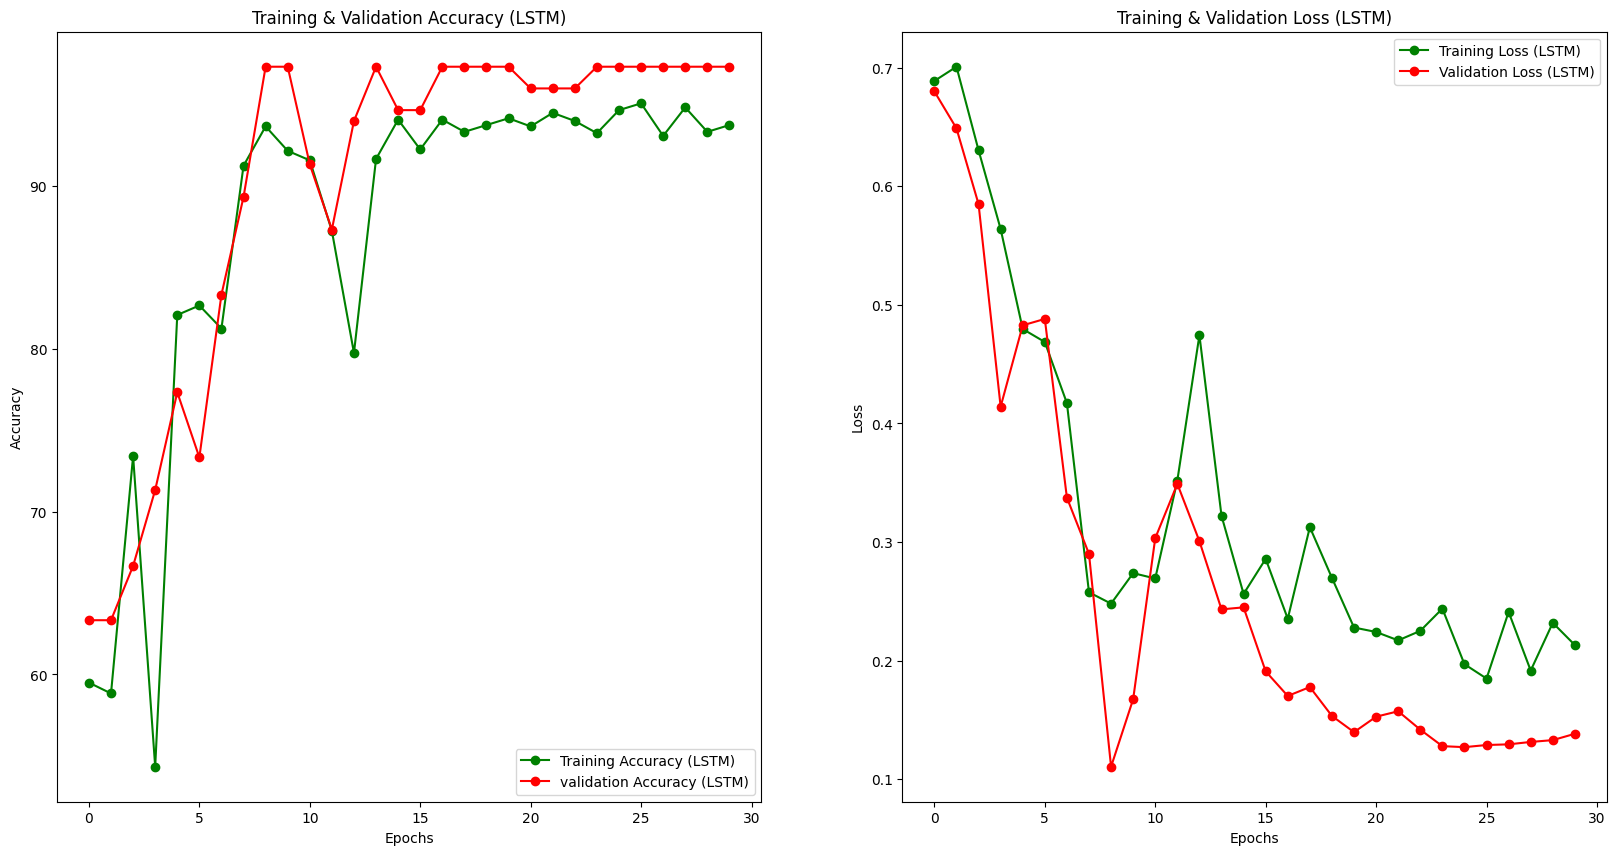

In [ ]:
epochs = [i for i in range(num_epochs)]
fig , ax = plt.subplots(1,2)
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_accs , 'go-' , label = 'Training Accuracy (LSTM)')
ax[0].plot(epochs , valid_accs_lstm , 'ro-' , label = 'validation Accuracy (LSTM)')
ax[0].set_title('Training & Validation Accuracy (LSTM)')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_losses , 'go-' , label = 'Training Loss (LSTM)')
ax[1].plot(epochs , valid_losses_lstm , 'ro-' , label = 'Validation Loss (LSTM)')
ax[1].set_title('Training & Validation Loss (LSTM)')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
plt.show()

##CNN

In [ ]:
from torch.nn import functional as F

class CNNModel(nn.Module):
    def __init__(self, embedding_dim, vocabulary_size, window_size: int = 16, filter_multiplier = 64, embeddings = None, fine_tuning = False):
      super().__init__()
      self.embedding_dim = embedding_dim 
      if embeddings:
        self.embeddings = nn.Embedding.from_pretrained(torch.FloatTensor(FastTextEmbeddings), freeze=not fine_tuning, padding_idx=0)

      else:
        self.embeddings = nn.Embedding(num_embeddings=vocabulary_size+1, embedding_dim=embedding_dim, padding_idx=0)

      self.conv1d = nn.Conv1d(embedding_dim, filter_multiplier, window_size)
      self.dropout = nn.Dropout(0.5)
      self.linear = nn.Linear(filter_multiplier, 1)

    def forward(self, inputs):
      x = self.embeddings(inputs)
      x = x.permute(0, 2, 1)
      x = self.conv1d(x)
      x = F.relu(x)
      x = F.max_pool1d(x, x.shape[2]).squeeze(2)
      x = self.dropout(x)
      output = torch.squeeze(self.linear(x))

      return output

In [ ]:
model_cnn = CNNModel(300, len(training_word2idx), 16, 64, embeddings = True, fine_tuning=True)
optimizer = optim.Adam(model_cnn.parameters(), lr=0.0025, betas=(0.9, 0.999))
criterion = nn.BCEWithLogitsLoss()

In [ ]:
train_losses_cnn, valid_losses_cnn, test_loss_cnn, train_accs_cnn, valid_accs_cnn, test_acc_cnn, test_preds_cnn = experiment(model_cnn, optimizer, criterion, num_epochs)

Beginning training...
Epoch 1:
Batch 0 : training loss = 0.6969545483589172; training acc = 48.0
Epoch 1 : Validation loss = 0.5599899291992188; Validation acc = 96.0
Epoch 2:
Batch 0 : training loss = 0.5319639444351196; training acc = 92.0
Epoch 2 : Validation loss = 0.3678552011648814; Validation acc = 97.33333333333333
Epoch 3:
Batch 0 : training loss = 0.3001491129398346; training acc = 98.0
Epoch 3 : Validation loss = 0.1988854060570399; Validation acc = 98.66666666666667
Epoch 4:
Batch 0 : training loss = 0.13368788361549377; training acc = 99.0
Epoch 4 : Validation loss = 0.10233058283726375; Validation acc = 98.66666666666667
Epoch 5:
Batch 0 : training loss = 0.06747127324342728; training acc = 99.0
Epoch 5 : Validation loss = 0.055279591431220375; Validation acc = 98.66666666666667
Epoch 6:
Batch 0 : training loss = 0.016149545088410378; training acc = 100.0
Epoch 6 : Validation loss = 0.03067832284917434; Validation acc = 100.0
Epoch 7:
Batch 0 : training loss = 0.004356583

In [ ]:
import statistics 
from statistics import mean
train_losses_cnn = [mean(train_loss) for train_loss in train_losses_cnn]
train_accs_cnn = [mean(train_acc) for train_acc in train_accs_cnn]

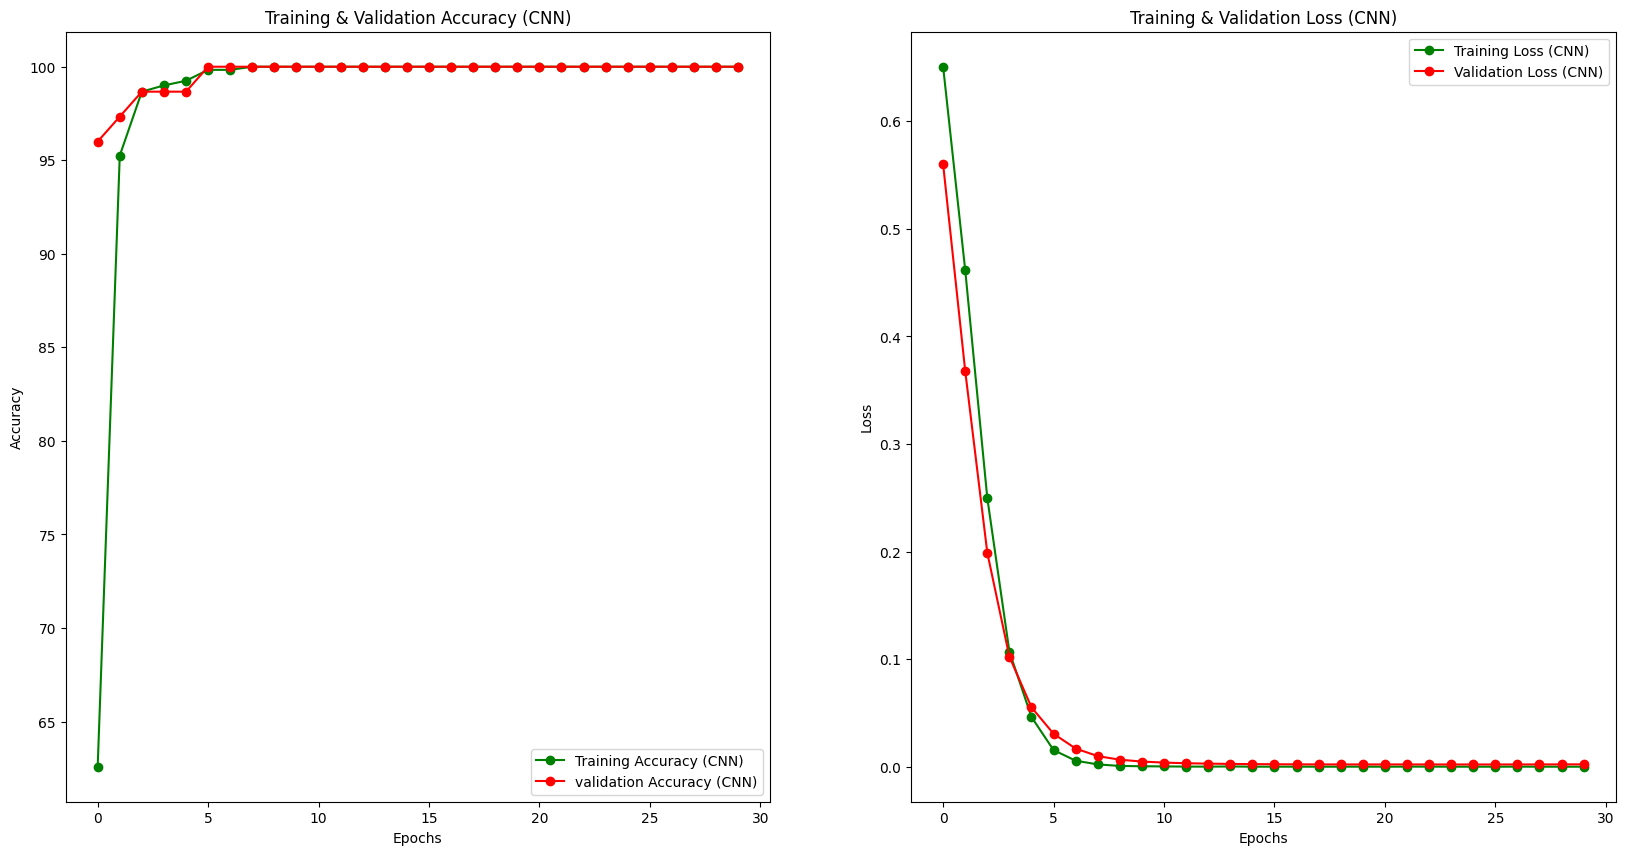

In [ ]:
epochs = [i for i in range(num_epochs)]
fig , ax = plt.subplots(1,2)
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_accs_cnn , 'go-' , label = 'Training Accuracy (CNN)')
ax[0].plot(epochs , valid_accs_cnn , 'ro-' , label = 'validation Accuracy (CNN)')
ax[0].set_title('Training & Validation Accuracy (CNN)')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_losses_cnn , 'go-' , label = 'Training Loss (CNN)')
ax[1].plot(epochs , valid_losses_cnn , 'ro-' , label = 'Validation Loss (CNN)')
ax[1].set_title('Training & Validation Loss (CNN)')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
plt.show()

#Eval

In [ ]:
preds = [(torch.sigmoid(t)>0.5).tolist() for t in test_preds_cnn]
preds = [int(t) for el in preds for t in el]

In [ ]:
preds[:20]

[1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0]

In [ ]:
test_y[:20]

array([1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0])

In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(preds,test_y)
cm_ = pd.DataFrame(cm , index = ['True','Fake'] , columns = ['True','Fake'])

Text(45.722222222222214, 0.5, 'Actual')

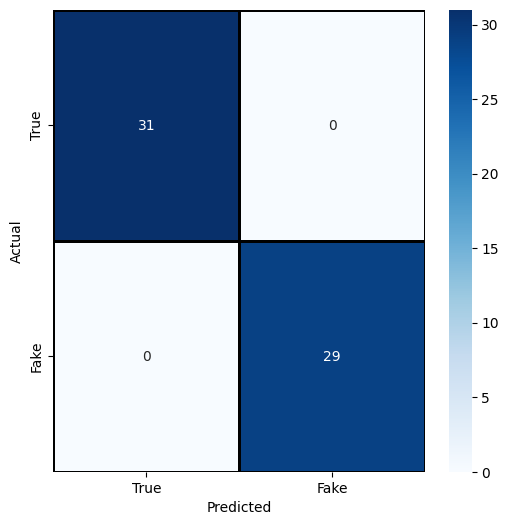

In [ ]:
plt.figure(figsize = (6,6))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='' , xticklabels = ['True','Fake'] , yticklabels = ['True','Fake'])
plt.xlabel("Predicted")
plt.ylabel("Actual")

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(test_y, preds, target_names = ['Predicted Fake','Predicted True']))

                precision    recall  f1-score   support

Predicted Fake       1.00      1.00      1.00        31
Predicted True       1.00      1.00      1.00        29

      accuracy                           1.00        60
     macro avg       1.00      1.00      1.00        60
  weighted avg       1.00      1.00      1.00        60



##Eval LSTM

In [ ]:
preds = [(torch.sigmoid(t)>0.5).tolist() for t in test_preds_lstm]
preds = [int(t) for el in preds for t in el]

In [ ]:
preds[:20]

[0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0]

In [ ]:
test_y[:20]

array([1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0])

In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(preds,test_y)
cm_ = pd.DataFrame(cm , index = ['True','Fake'] , columns = ['True','Fake'])

Text(45.722222222222214, 0.5, 'Actual')

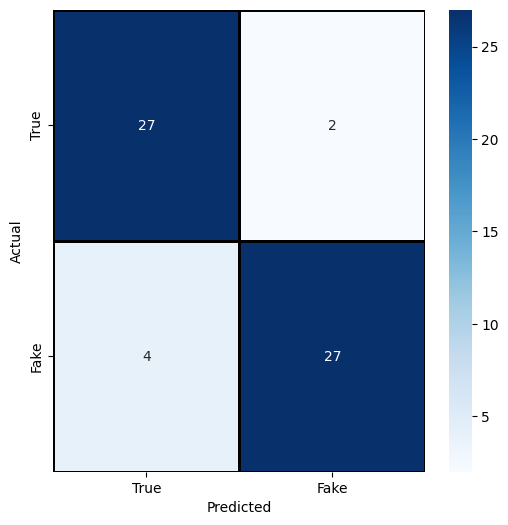

In [ ]:
plt.figure(figsize = (6,6))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='' , xticklabels = ['True','Fake'] , yticklabels = ['True','Fake'])
plt.xlabel("Predicted")
plt.ylabel("Actual")

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(test_y, preds, target_names = ['Predicted Fake','Predicted True']))

                precision    recall  f1-score   support

Predicted Fake       0.93      0.87      0.90        31
Predicted True       0.87      0.93      0.90        29

      accuracy                           0.90        60
     macro avg       0.90      0.90      0.90        60
  weighted avg       0.90      0.90      0.90        60

